# Metrics

In [ ]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
import os
from scipy.optimize import linear_sum_assignment

os.chdir('../')

from tgmm import GaussianMixture, ClusteringMetrics, dynamic_figsize, plot_gmm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
random_state = 42
np.random.seed(random_state)
torch.manual_seed(random_state)

if device == 'cuda':
    torch.cuda.manual_seed(random_state)
    print('CUDA version:', torch.version.cuda)
    print('Device:', torch.cuda.get_device_name(0))
else:
    print('Using CPU')

Using CPU


/home/asp/miniforge3/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


---
## Synthetic Data Generation

The synthetic dataset is generated by combining four Gaussian components:

- **Component 1:** Centered at `[0, 2]` with spherical covariance.
- **Component 2:** Centered at `[2, -2]` with spherical covariance (fewer points).
- **Component 3:** Centered at `[0, 0]` with diagonal covariance.
- **Component 4:** Centered at `[2, 2]` with full covariance.

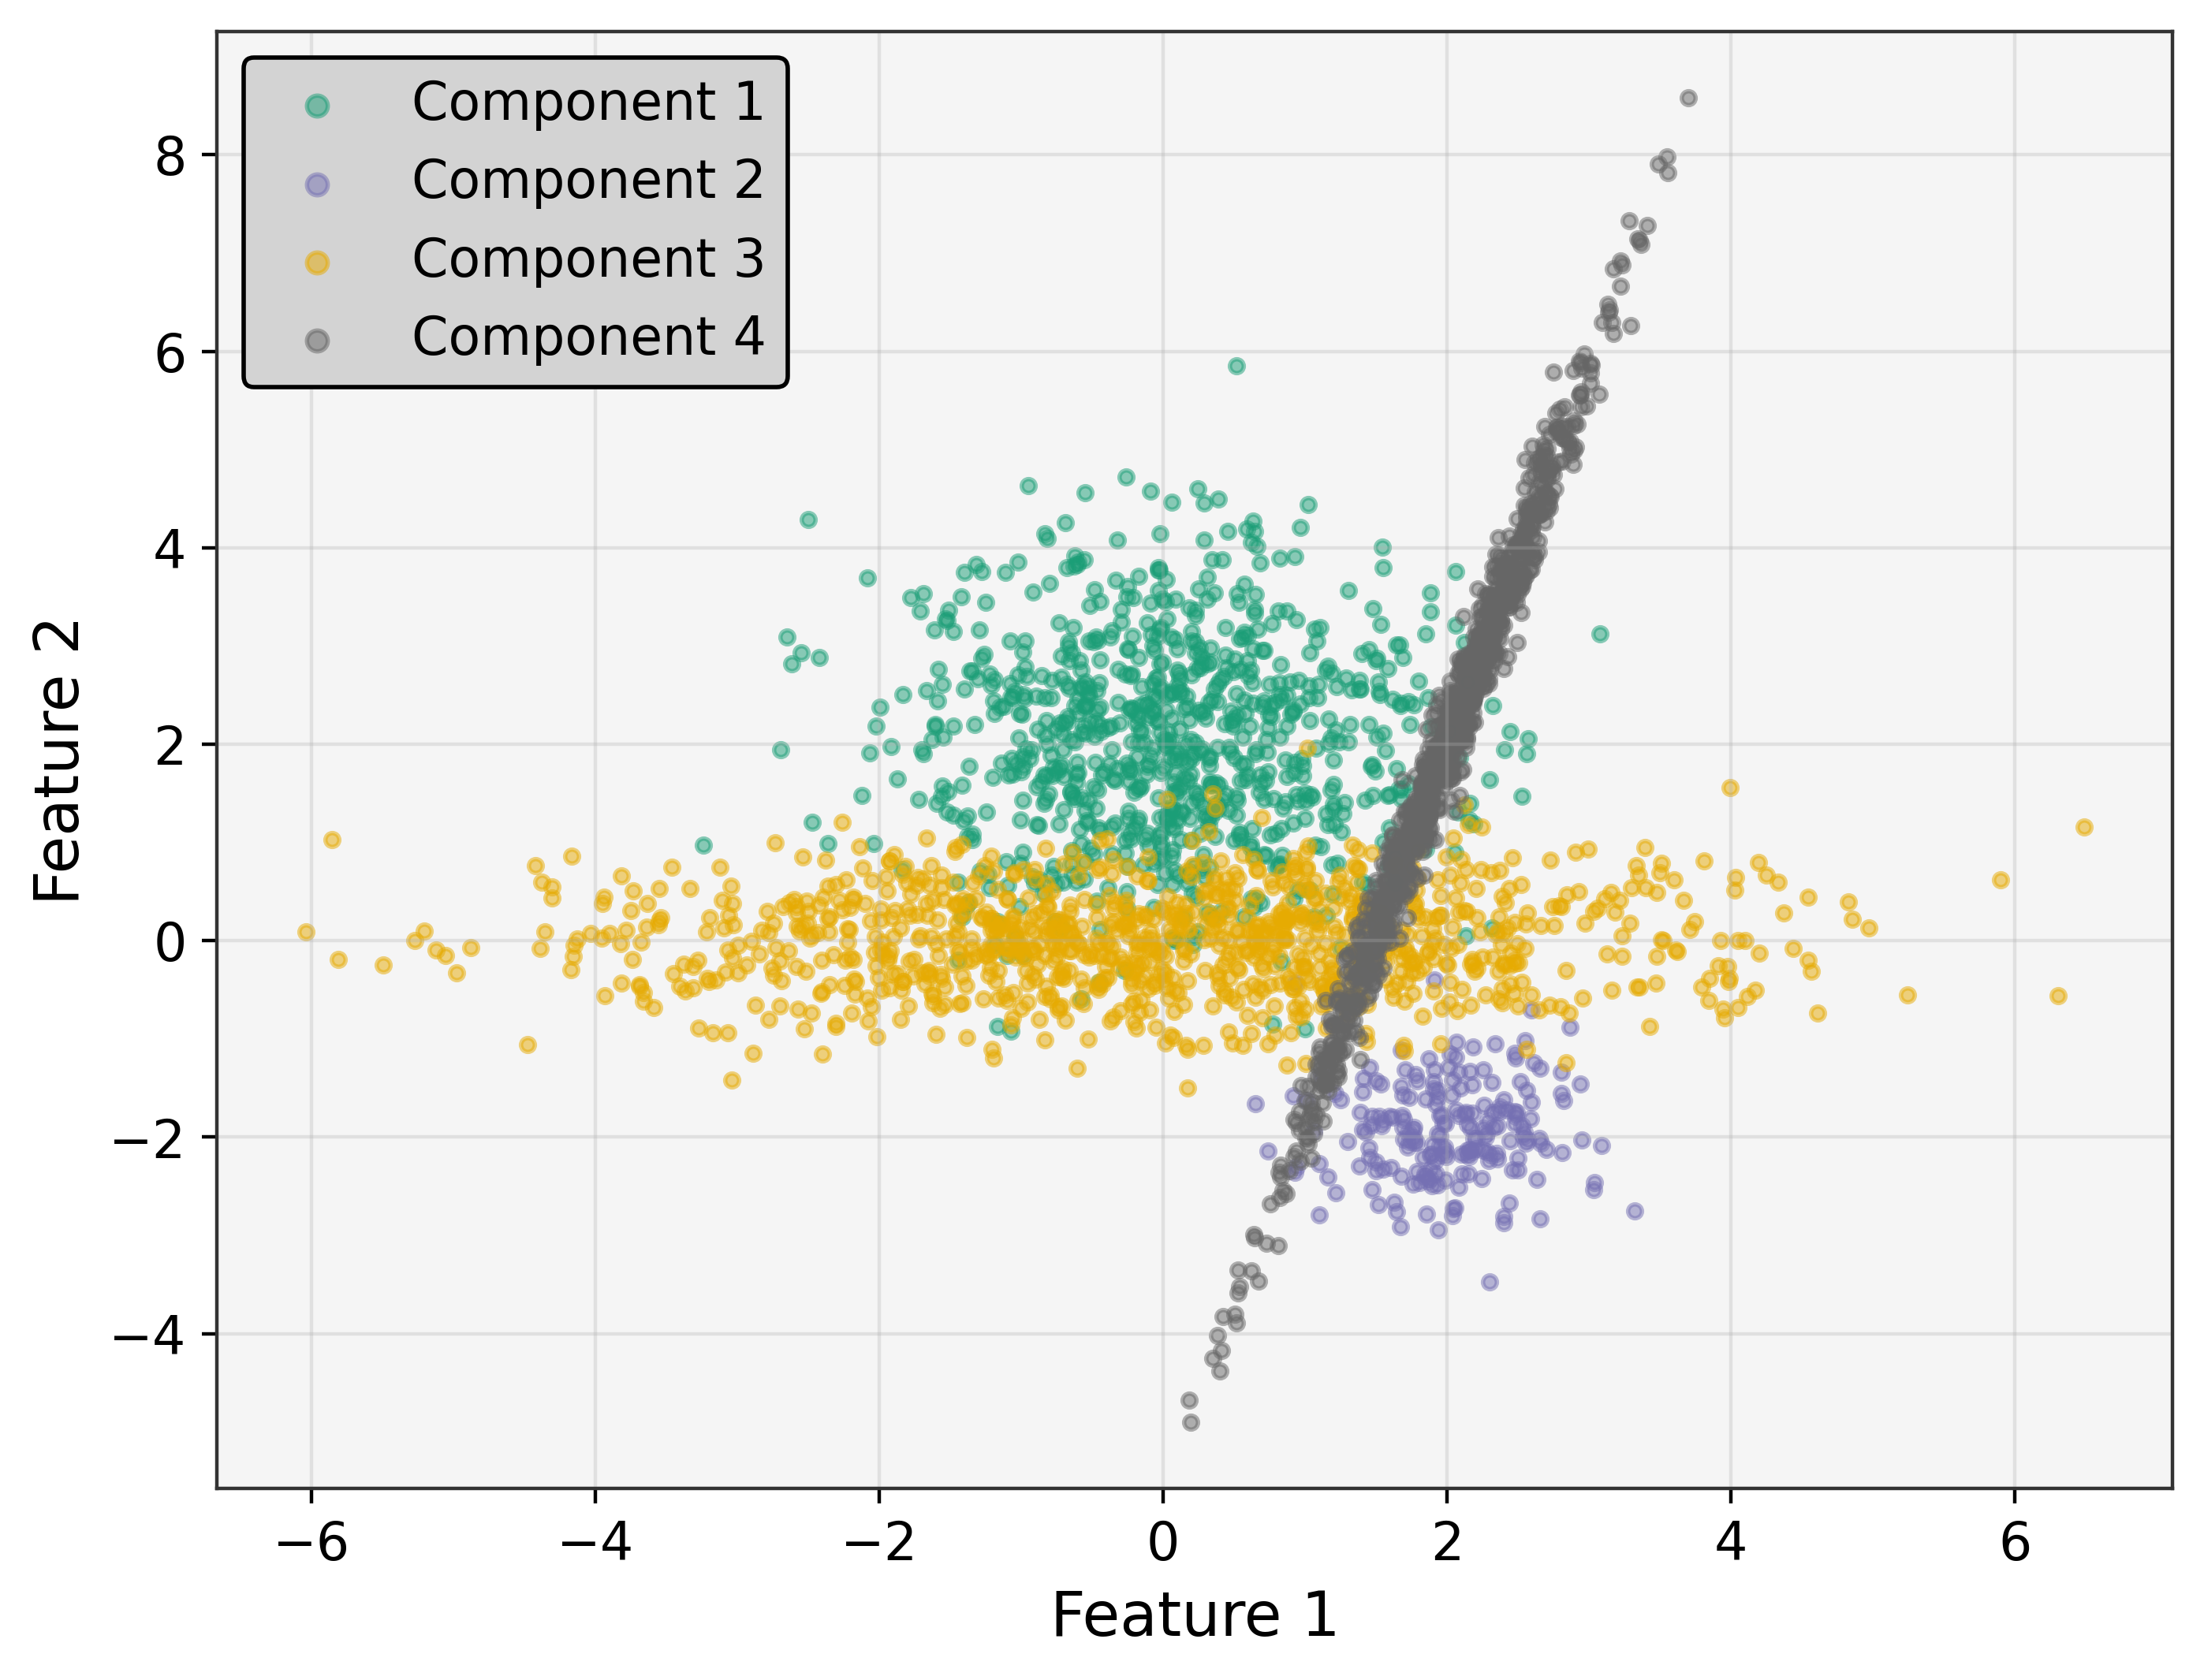

In [2]:
n_samples = [800, 200, 1000, 1000]
centers = [np.array([0, 2]),
           np.array([2, -2]),
           np.array([0, 0]),
           np.array([2, 2])]
covs = [
    1.0 * np.eye(2),                    # spherical covariance
    0.5 * np.eye(2),                    # spherical covariance, fewer points
    np.array([[2, 0], [0, 0.5]]),       # diagonal covariance
    np.array([[0.2, 0.5], [0.5, 2]])    # full covariance
]

components = []
for n, center, cov in zip(n_samples, centers, covs):
    samples = np.dot(np.random.randn(n, 2), cov) + center
    components.append(samples)

X = np.vstack(components)
labels = np.concatenate([i * np.ones(n) for i, n in enumerate(n_samples)])
legend_labels = [f'Component {i+1}' for i in range(len(n_samples))]
y_true = labels

X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(labels, dtype=torch.long, device=device)

n_features = X.shape[1]
n_components = len(n_samples)

plot_gmm(X=X, labels=labels, title='Original Data', legend_labels=legend_labels)
plt.show()

---

## Unsupervised Clustering Metrics Definitions

Below are the definitions of the unsupervised clustering metrics used in this thesis.



### Silhouette Score

The **Silhouette Score** quantifies how similar each data point is to its own cluster compared to other clusters. For a data point $ \mathbf{x}_i $ belonging to cluster $ C_k $, the silhouette value is defined as

$$
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}},
$$

where:
- $ a(i) $ is the average distance between $\mathbf{x}_i$ and all other points in the same cluster $ C_k $ (i.e., the intra-cluster distance),
- $ b(i) $ is the smallest average distance between $\mathbf{x}_i$ and all points in any other cluster (i.e., the nearest-cluster distance).

A high silhouette score (close to 1) indicates that the data point is well matched to its own cluster and poorly matched to neighboring clusters.



### Davies-Bouldin Index

The **Davies-Bouldin Index (DB)** measures the average similarity between each cluster and its most similar one. It is defined as

$$
\text{DB} = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \frac{S_i + S_j}{M_{ij}},
$$

where:
- $ S_i $ is the average distance between the points in cluster $ i $ and the centroid of $ i $,
- $ M_{ij} $ is the distance between the centroids of clusters $ i $ and $ j $.

Lower values of the Davies-Bouldin Index indicate better clustering quality, as they reflect smaller within-cluster dispersion relative to the separation between clusters.



### Calinski-Harabasz Score

The **Calinski-Harabasz Score (CH)** (also known as the Variance Ratio Criterion) is given by

$$
\text{CH} = \frac{\text{Between-cluster dispersion} / (k - 1)}{\text{Within-cluster dispersion} / (N - k)},
$$

where:
- $ k $ is the number of clusters,
- $ N $ is the total number of samples.

Higher Calinski-Harabasz scores suggest a model in which clusters are dense and well separated.



### Dunn Index

The **Dunn Index** seeks to identify clusters that are both compact and well separated. It is defined as

$$
D = \frac{\min\limits_{i \neq j} d(C_i, C_j)}{\max\limits_{k} \mathrm{diam}(C_k)},
$$

where:
- $ d(C_i, C_j) $ is the minimum distance between any two points in clusters $ C_i $ and $ C_j $,
- $ \mathrm{diam}(C_k) $ is the maximum distance between any two points in cluster $ C_k $.

A higher Dunn Index indicates better clustering, meaning that the clusters are more compact and well separated.



### Bayesian Information Criterion (BIC)

The **Bayesian Information Criterion (BIC)** is used for model selection by penalizing model complexity while rewarding goodness-of-fit. It is computed as

$$
\text{BIC} = n_{\text{params}} \cdot \ln(N) - 2 \cdot \mathcal{L},
$$

where:
- $ n_{\text{params}} $ is the number of free parameters in the model,
- $ N $ is the number of samples,
- $ \mathcal{L} $ is the log-likelihood of the model.

Lower BIC values indicate a model that better balances fit and simplicity.



### Akaike Information Criterion (AIC)

The **Akaike Information Criterion (AIC)** is another metric for model selection defined as

$$
\text{AIC} = 2 \cdot n_{\text{params}} - 2 \cdot \mathcal{L}.
$$

As with BIC, lower AIC values suggest a model that achieves a good trade-off between complexity and fit quality.



**Note:** In practice, the ideal number of clusters is typically determined by seeking a maximum in the Silhouette Score, Calinski-Harabasz Score, and Dunn Index, while simultaneously looking for minima in the Davies-Bouldin Index, AIC, and BIC.


Evaluating range: 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]


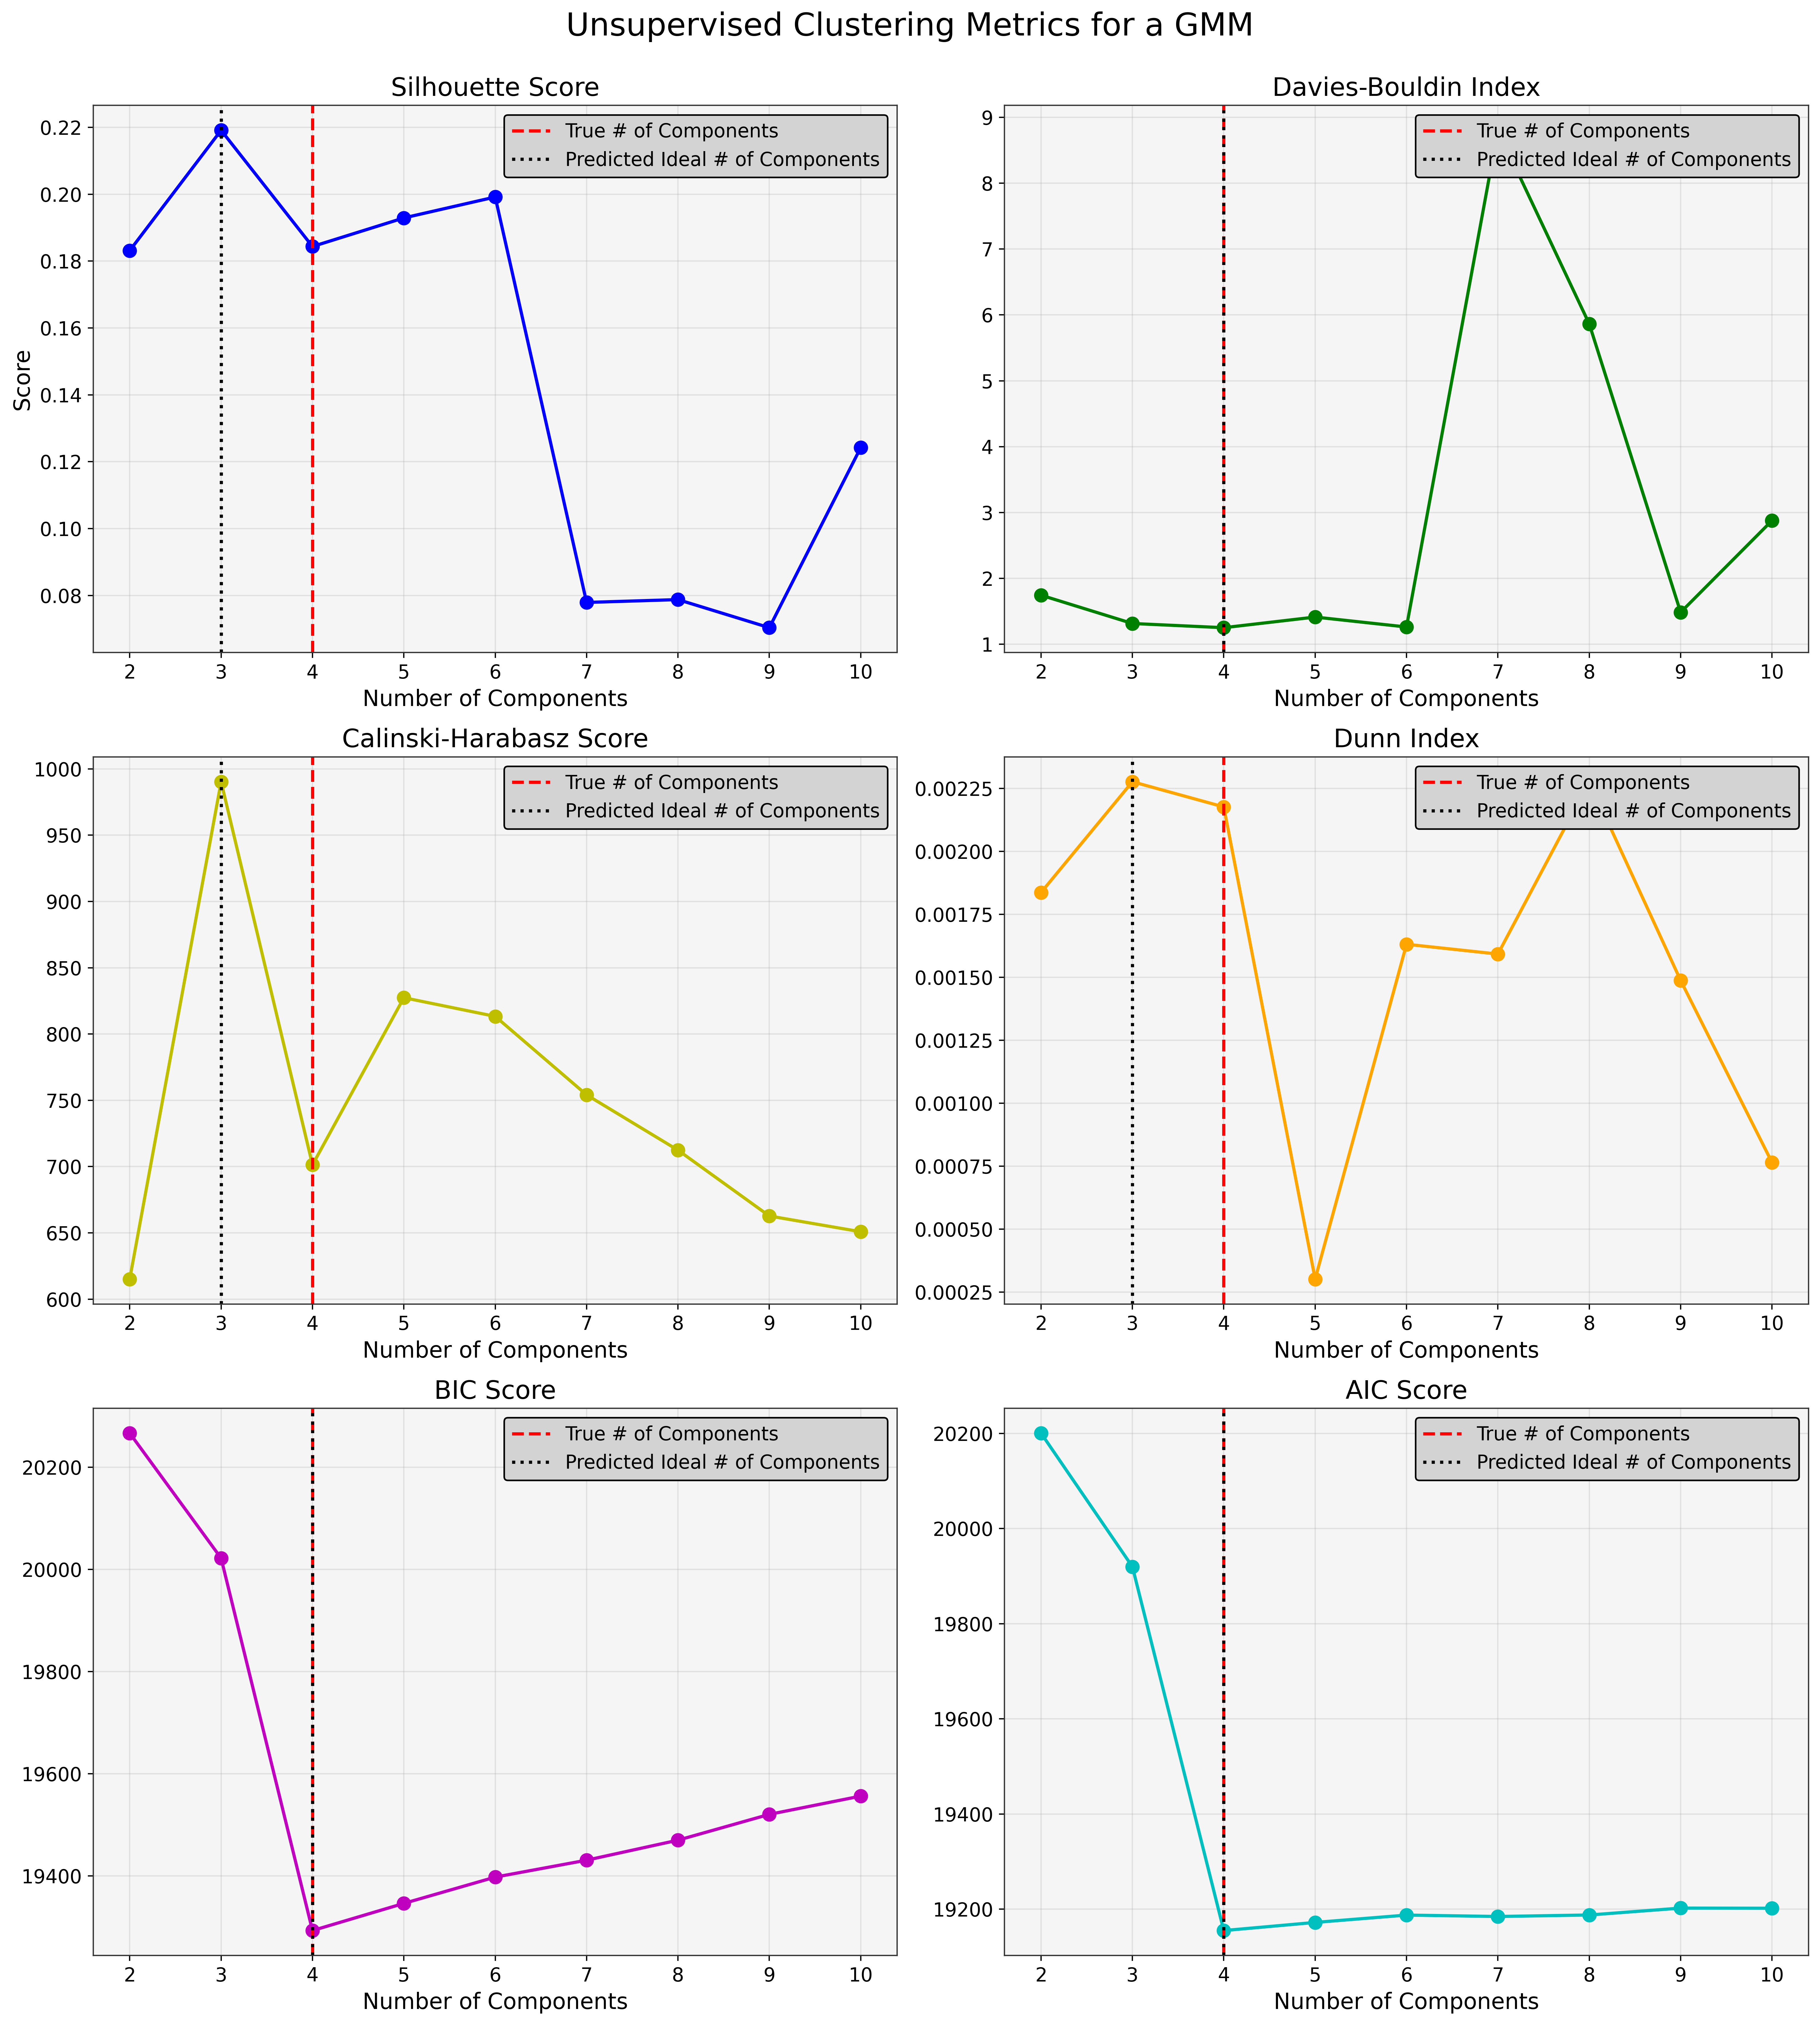

=== Best Number of Components According to Each Metric ===
Silhouette Best: 3
Davies-Bouldin Best (lowest): 4
Calinski-Harabasz Best: 3
Dunn Index Best: 3
BIC Best (lowest): 4
AIC Best (lowest): 4


In [3]:
components_range = np.arange(2, 11)
silhouette_vals = torch.zeros(len(components_range), device=device)
davies_vals = torch.zeros(len(components_range), device=device)
calinski_vals = torch.zeros(len(components_range), device=device)
dunn_vals = torch.zeros(len(components_range), device=device)
bic_vals = torch.zeros(len(components_range), device=device)
aic_vals = torch.zeros(len(components_range), device=device)

# Fit a GMM for each n in components_range
for i, n in tqdm(enumerate(components_range), total=len(components_range), desc="Evaluating range"):
    gmm = GaussianMixture(
        n_features=n_features,
        n_components=n,
        covariance_type='full',
        max_iter=1000,
        init_params='kmeans',
        device=device
    )
    # Fit
    gmm.fit(X_tensor)
    labels_pred = gmm.predict(X_tensor)  # shape (N,)

    # Compute unsupervised metrics
    silhouette_vals[i] = ClusteringMetrics.silhouette_score(X_tensor, labels_pred, n_components=n)
    davies_vals[i] = ClusteringMetrics.davies_bouldin_index(X_tensor, labels_pred, n_components=n)
    calinski_vals[i] = ClusteringMetrics.calinski_harabasz_score(X_tensor, labels_pred, n_components=n)
    dunn_vals[i] = ClusteringMetrics.dunn_index(X_tensor, labels_pred, n_components=n)
    bic_vals[i] = ClusteringMetrics.bic_score(gmm.lower_bound_, X_tensor, n, gmm.covariance_type)
    aic_vals[i] = ClusteringMetrics.aic_score(gmm.lower_bound_, X_tensor, n, gmm.covariance_type)

# Compute the predicted ideal number of components for each metric
sil_best = components_range[torch.argmax(silhouette_vals)].item()
davies_best = components_range[torch.argmin(davies_vals)].item()
calinski_best = components_range[torch.argmax(calinski_vals)].item()
dunn_best = components_range[torch.argmax(dunn_vals)].item()
bic_best = components_range[torch.argmin(bic_vals)].item()
aic_best = components_range[torch.argmin(aic_vals)].item()

# Create a 3-rows x 2-columns figure (3 rows, 2 columns)
nrows, ncols = 3, 2
fig, axs = plt.subplots(nrows, ncols, figsize=dynamic_figsize(nrows, ncols))

# 1) Silhouette Score (Row 1, Col 1)
axs[0, 0].plot(components_range, silhouette_vals.cpu(), 'o-b')
axs[0, 0].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[0, 0].axvline(x=sil_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[0, 0].set_title('Silhouette Score')
axs[0, 0].set_xlabel('Number of Components')
axs[0, 0].set_ylabel('Score')
axs[0, 0].grid(True)
axs[0, 0].legend(loc='upper right')

# 2) Davies-Bouldin Index (Row 1, Col 2)
axs[0, 1].plot(components_range, davies_vals.cpu(), 'o-g')
axs[0, 1].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[0, 1].axvline(x=davies_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[0, 1].set_title('Davies-Bouldin Index')
axs[0, 1].set_xlabel('Number of Components')
axs[0, 1].grid(True)
axs[0, 1].legend(loc='upper right')

# 3) Calinski-Harabasz Score (Row 2, Col 1)
axs[1, 0].plot(components_range, calinski_vals.cpu(), 'o-y')
axs[1, 0].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[1, 0].axvline(x=calinski_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[1, 0].set_title('Calinski-Harabasz Score')
axs[1, 0].set_xlabel('Number of Components')
axs[1, 0].grid(True)
axs[1, 0].legend(loc='upper right')

# 4) Dunn Index (Row 2, Col 2)
axs[1, 1].plot(components_range, dunn_vals.cpu(), 'o-', color='orange')
axs[1, 1].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[1, 1].axvline(x=dunn_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[1, 1].set_title('Dunn Index')
axs[1, 1].set_xlabel('Number of Components')
axs[1, 1].grid(True)
axs[1, 1].legend(loc='upper right')

# 5) BIC Score (Row 3, Col 1)
axs[2, 0].plot(components_range, bic_vals.cpu(), 'o-m')
axs[2, 0].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[2, 0].axvline(x=bic_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[2, 0].set_title('BIC Score')
axs[2, 0].set_xlabel('Number of Components')
axs[2, 0].grid(True)
axs[2, 0].legend(loc='upper right')

# 6) AIC Score (Row 3, Col 2)
axs[2, 1].plot(components_range, aic_vals.cpu(), 'o-c')
axs[2, 1].axvline(x=n_components, color='r', linestyle='--', label='True # of Components')
axs[2, 1].axvline(x=aic_best, color='k', linestyle=':', label='Predicted Ideal # of Components')
axs[2, 1].set_title('AIC Score')
axs[2, 1].set_xlabel('Number of Components')
axs[2, 1].grid(True)
axs[2, 1].legend(loc='upper right')

plt.suptitle("Unsupervised Clustering Metrics for a GMM")
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

print("=== Best Number of Components According to Each Metric ===")
print(f"Silhouette Best: {sil_best}")
print(f"Davies-Bouldin Best (lowest): {davies_best}")
print(f"Calinski-Harabasz Best: {calinski_best}")
print(f"Dunn Index Best: {dunn_best}")
print(f"BIC Best (lowest): {bic_best}")
print(f"AIC Best (lowest): {aic_best}")


In [4]:
# Scikit-learn for comparison
from sklearn.mixture import GaussianMixture as SklearnGMM
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    fowlkes_mallows_score,
    homogeneity_score,
    mutual_info_score,
    adjusted_mutual_info_score,
    completeness_score,
    v_measure_score,
    rand_score
)

gmm = GaussianMixture(
    n_features=n_features,
    n_components=n_components,
    covariance_type='full',
    max_iter=1000,
    init_params='kmeans',
    device=device
)
gmm.fit(X_tensor)
labels_pred = gmm.predict(X_tensor)

# Metrics with custom ClusteringMetrics
metrics_to_compare = [
    "rand_score",
    "adjusted_rand_score",
    "mutual_info_score",
    "normalized_mutual_info_score",
    "adjusted_mutual_info_score",
    "fowlkes_mallows_score",
    "homogeneity_score",
    "completeness_score",
    "v_measure_score",
    "silhouette_score",
    "davies_bouldin_index",
    "calinski_harabasz_score",
    "purity_score",   # Torch-only metric
    "dunn_index",     # Torch-only metric
    "bic_score",      # Compare Torch vs Sklearn BIC
    "aic_score",      # Compare Torch vs Sklearn AIC
]
scores_torch = ClusteringMetrics.evaluate_clustering(
    gmm,
    X_tensor,
    true_labels=y_tensor,
    metrics=metrics_to_compare
)

# Compare with sklearn
X_np = X_tensor.cpu().numpy()
y_np = y_tensor.cpu().numpy()
labels_pred_np = labels_pred.cpu().numpy()

sk_gmm = SklearnGMM(n_components=n_components, covariance_type='full', max_iter=1000, init_params='kmeans')
sk_gmm.fit(X_np)

scores_sklearn = {
    "rand_score": rand_score(y_np, labels_pred_np),
    "adjusted_rand_score": adjusted_rand_score(y_np, labels_pred_np),
    "mutual_info_score": mutual_info_score(y_np, labels_pred_np),
    "normalized_mutual_info_score": normalized_mutual_info_score(y_np, labels_pred_np),
    "adjusted_mutual_info_score": adjusted_mutual_info_score(y_np, labels_pred_np),
    "fowlkes_mallows_score": fowlkes_mallows_score(y_np, labels_pred_np),
    "homogeneity_score": homogeneity_score(y_np, labels_pred_np),
    "completeness_score": completeness_score(y_np, labels_pred_np),
    "v_measure_score": v_measure_score(y_np, labels_pred_np),
    "silhouette_score": silhouette_score(X_np, labels_pred_np),
    "davies_bouldin_index": davies_bouldin_score(X_np, labels_pred_np),
    "calinski_harabasz_score": calinski_harabasz_score(X_np, labels_pred_np),
}
sk_bic = sk_gmm.bic(X_np)
sk_aic = sk_gmm.aic(X_np)



rows = []
for metric in metrics_to_compare:
    # Retrieve the Torch metric score if available.
    torch_val = scores_torch.get(metric, None)
    
    # Retrieve the scikit-learn metric score if available.
    if metric in scores_sklearn:
        sklearn_val = scores_sklearn.get(metric)
    elif metric == "bic_score":
        sklearn_val = sk_bic
    elif metric == "aic_score":
        sklearn_val = sk_aic
    else:
        sklearn_val = None
    
    # Calculate the absolute difference if both values are available.
    if torch_val is not None and sklearn_val is not None:
        abs_diff = abs(torch_val - sklearn_val)
    else:
        abs_diff = None
    
    rows.append({
        "Metric": metric,
        "Torch Score": torch_val,
        "Sklearn Score": sklearn_val,
        "Absolute Difference": abs_diff,
    })

df_metrics = pd.DataFrame(rows)
print(df_metrics)


                          Metric   Torch Score  Sklearn Score  \
0                     rand_score      0.923271       0.923271   
1            adjusted_rand_score      0.817356       0.817356   
2              mutual_info_score      0.981350       0.981350   
3   normalized_mutual_info_score      0.778634       0.778634   
4     adjusted_mutual_info_score      0.778541       0.778370   
5          fowlkes_mallows_score      0.872198       0.872198   
6              homogeneity_score      0.773706       0.775518   
7             completeness_score      0.783523       0.781776   
8                v_measure_score      0.778584       0.778634   
9               silhouette_score      0.184275       0.184275   
10          davies_bouldin_index      1.252935       1.252935   
11       calinski_harabasz_score    701.043823     701.044158   
12                  purity_score      0.931333            NaN   
13                    dunn_index      0.002177            NaN   
14                     bi

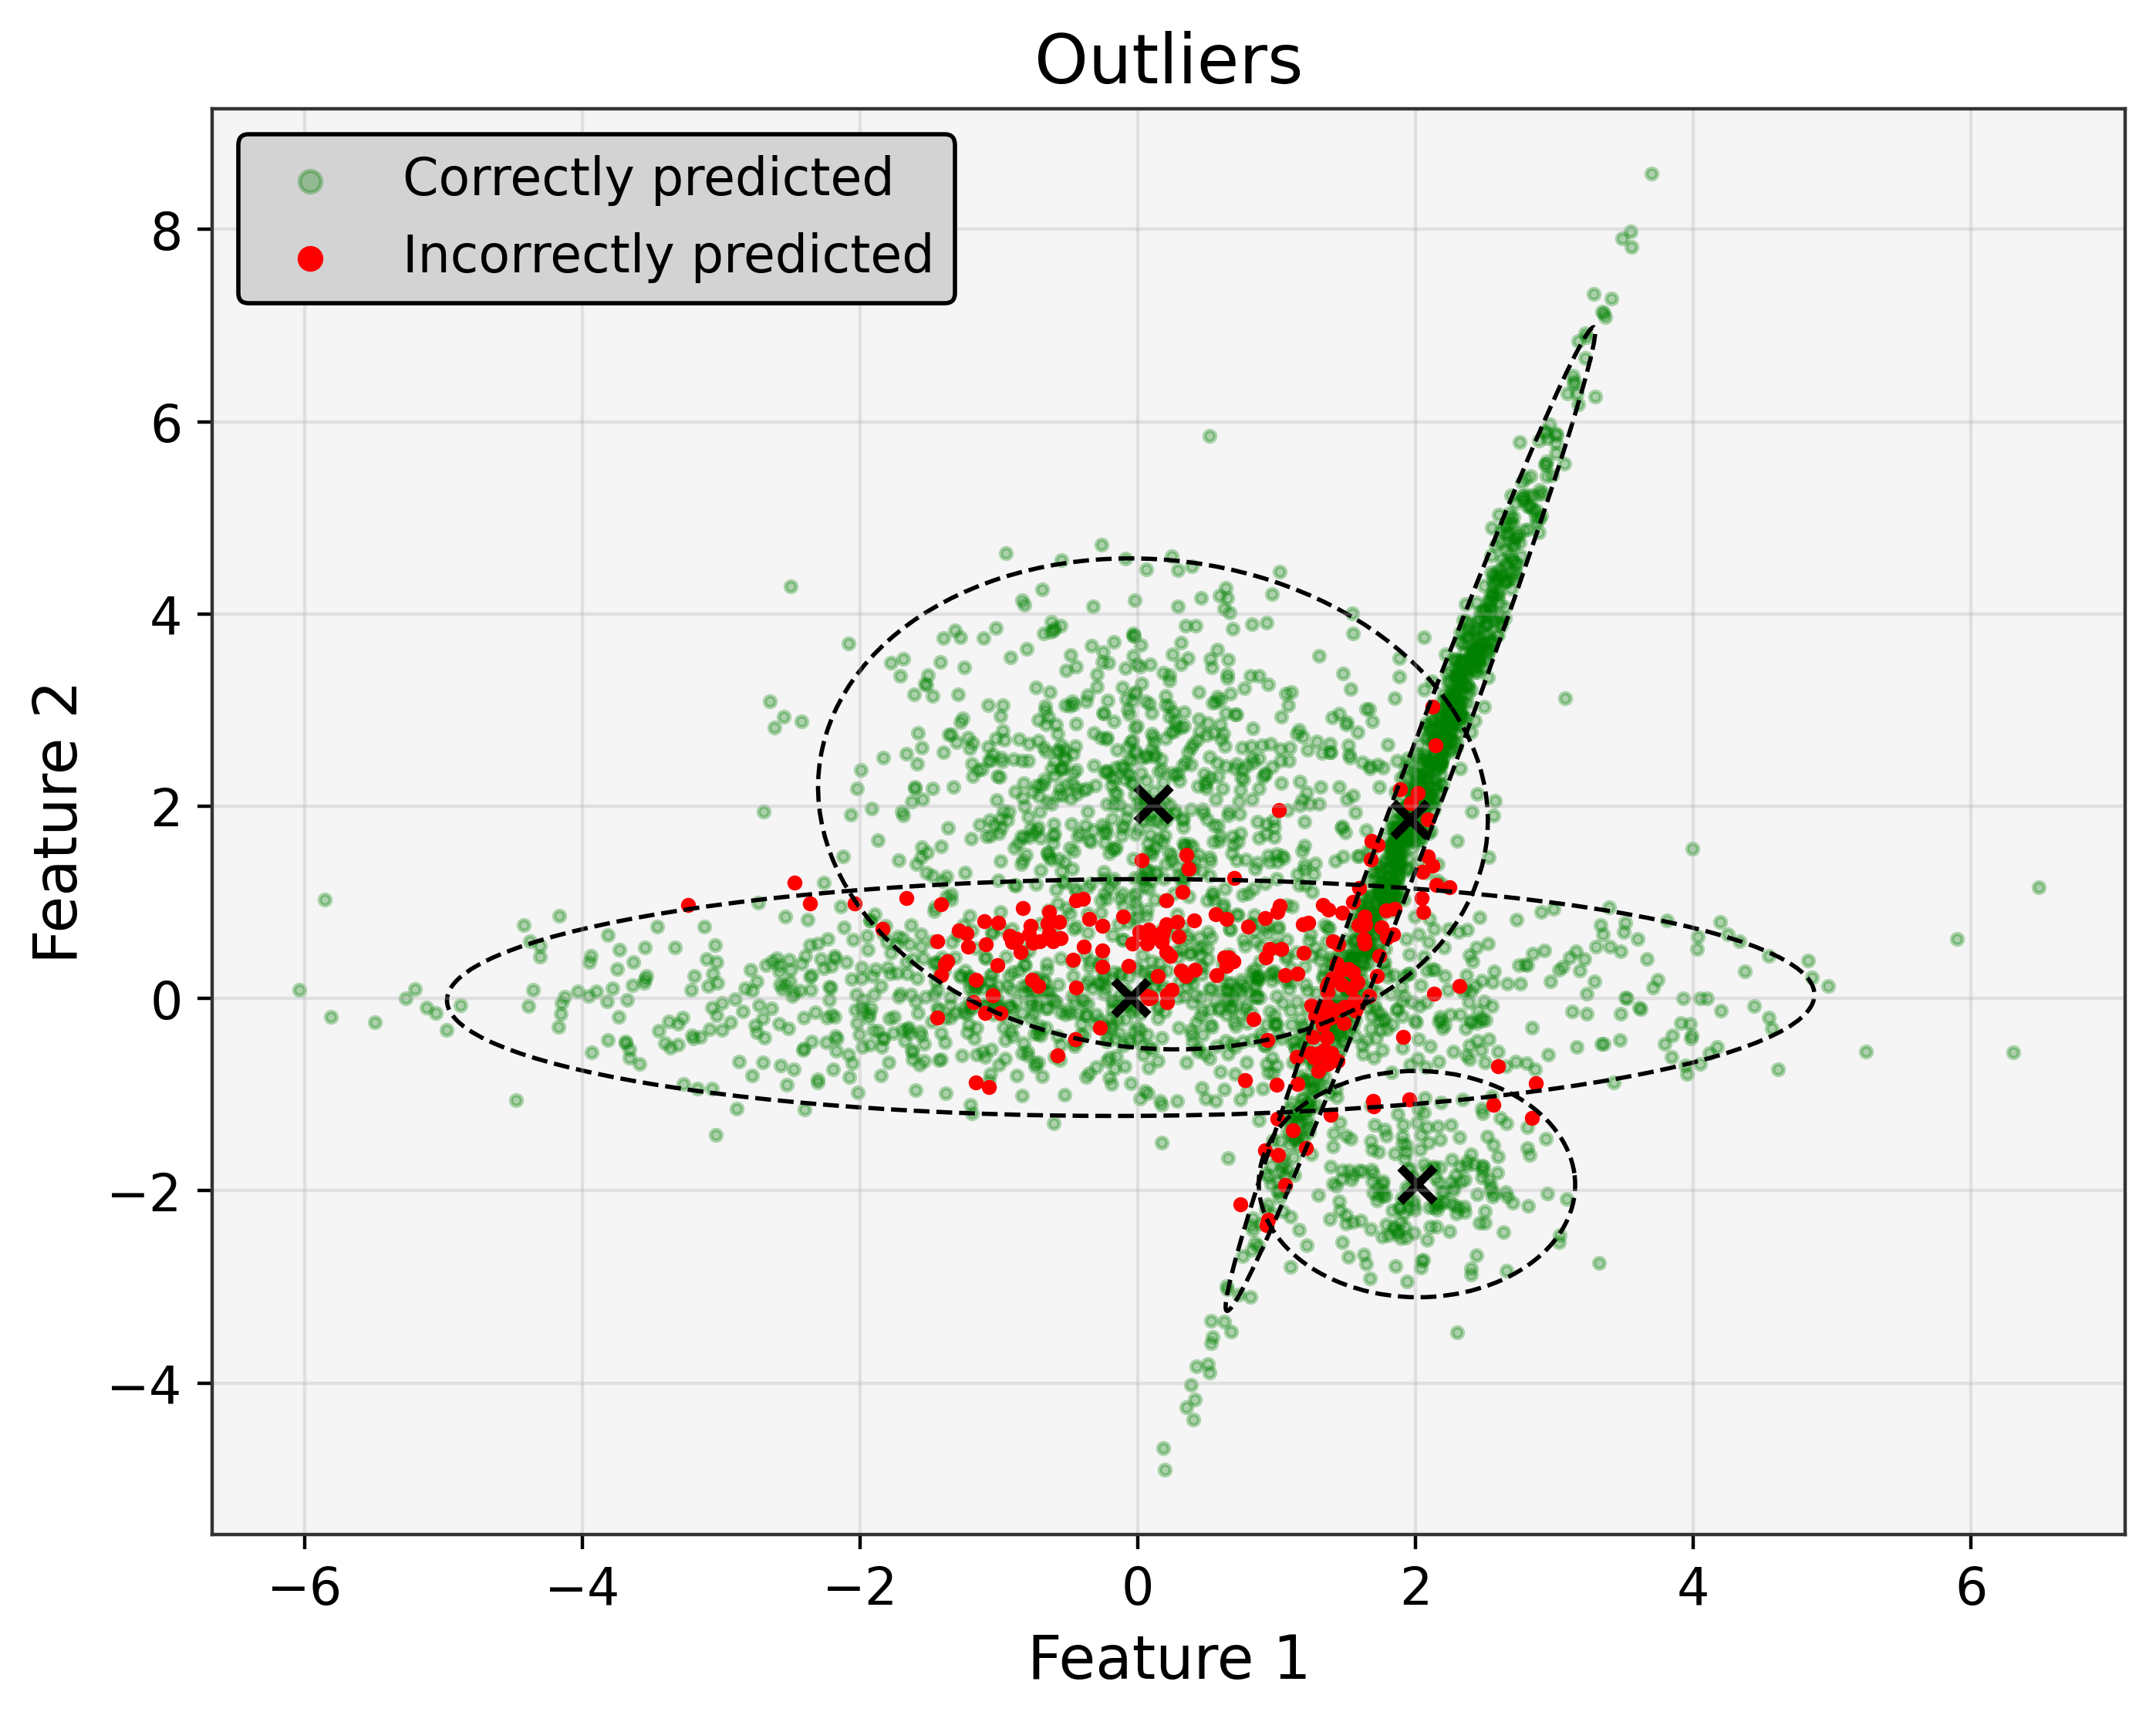

In [8]:

# Assume X_np is already 2D and convert it to a tensor if needed
X_pca = X_np  # Data is 2D already.
X_pca_tensor = torch.tensor(X_pca, dtype=torch.float32, device=device)

# Function to match predicted labels to ground truth using the Hungarian algorithm.
def match_labels(y_true_tensor, y_pred_tensor):
    y_true_cpu = y_true_tensor.cpu().long()
    y_pred_cpu = y_pred_tensor.cpu().long()
    max_true = y_true_cpu.max().item() + 1
    max_pred = y_pred_cpu.max().item() + 1

    # Build contingency matrix
    cont = np.zeros((max_true, max_pred), dtype=int)
    for i in range(y_true_cpu.size(0)):
        cont[y_true_cpu[i], y_pred_cpu[i]] += 1

    row_ind, col_ind = linear_sum_assignment(-cont)  # maximize the total assignment
    mapping = {col_ind[j]: row_ind[j] for j in range(len(row_ind))}

    matched_labels = np.array([mapping.get(p, p) for p in y_pred_cpu.numpy()], dtype=int)
    return matched_labels

matched_pred = match_labels(y_tensor, labels_pred)

fig, ax = plt.subplots(figsize=dynamic_figsize(1, 1))
plot_gmm(X=X_np, gmm=gmm, labels=labels_pred, true_labels=y_tensor, ax=ax, mode='outliers', title='GMM Predictions')
plt.show()


Confusion Matrix:
 tensor([[694,   0,  91,  15],
        [  0, 188,   4,   8],
        [ 32,   5, 925,  38],
        [  3,   1,   9, 987]], dtype=torch.int32)

Classification Report:
 {0: {'precision': 0.9519890260631001, 'recall': 0.8675, 'f1-score': 0.9077828646173971, 'support': 800, 'jaccard': 0.8311377245508982, 'roc_auc': 0.9026442766189575}, 1: {'precision': 0.9690721649484536, 'recall': 0.94, 'f1-score': 0.9543147208121826, 'support': 200, 'jaccard': 0.912621359223301, 'roc_auc': 0.9455070495605469}, 2: {'precision': 0.8989310009718173, 'recall': 0.925, 'f1-score': 0.9117792015771317, 'support': 1000, 'jaccard': 0.8378623188405797, 'roc_auc': 0.9339924454689026}, 3: {'precision': 0.941793893129771, 'recall': 0.987, 'f1-score': 0.9638671875, 'support': 1000, 'jaccard': 0.9302544769085768, 'roc_auc': 0.9784834980964661}}


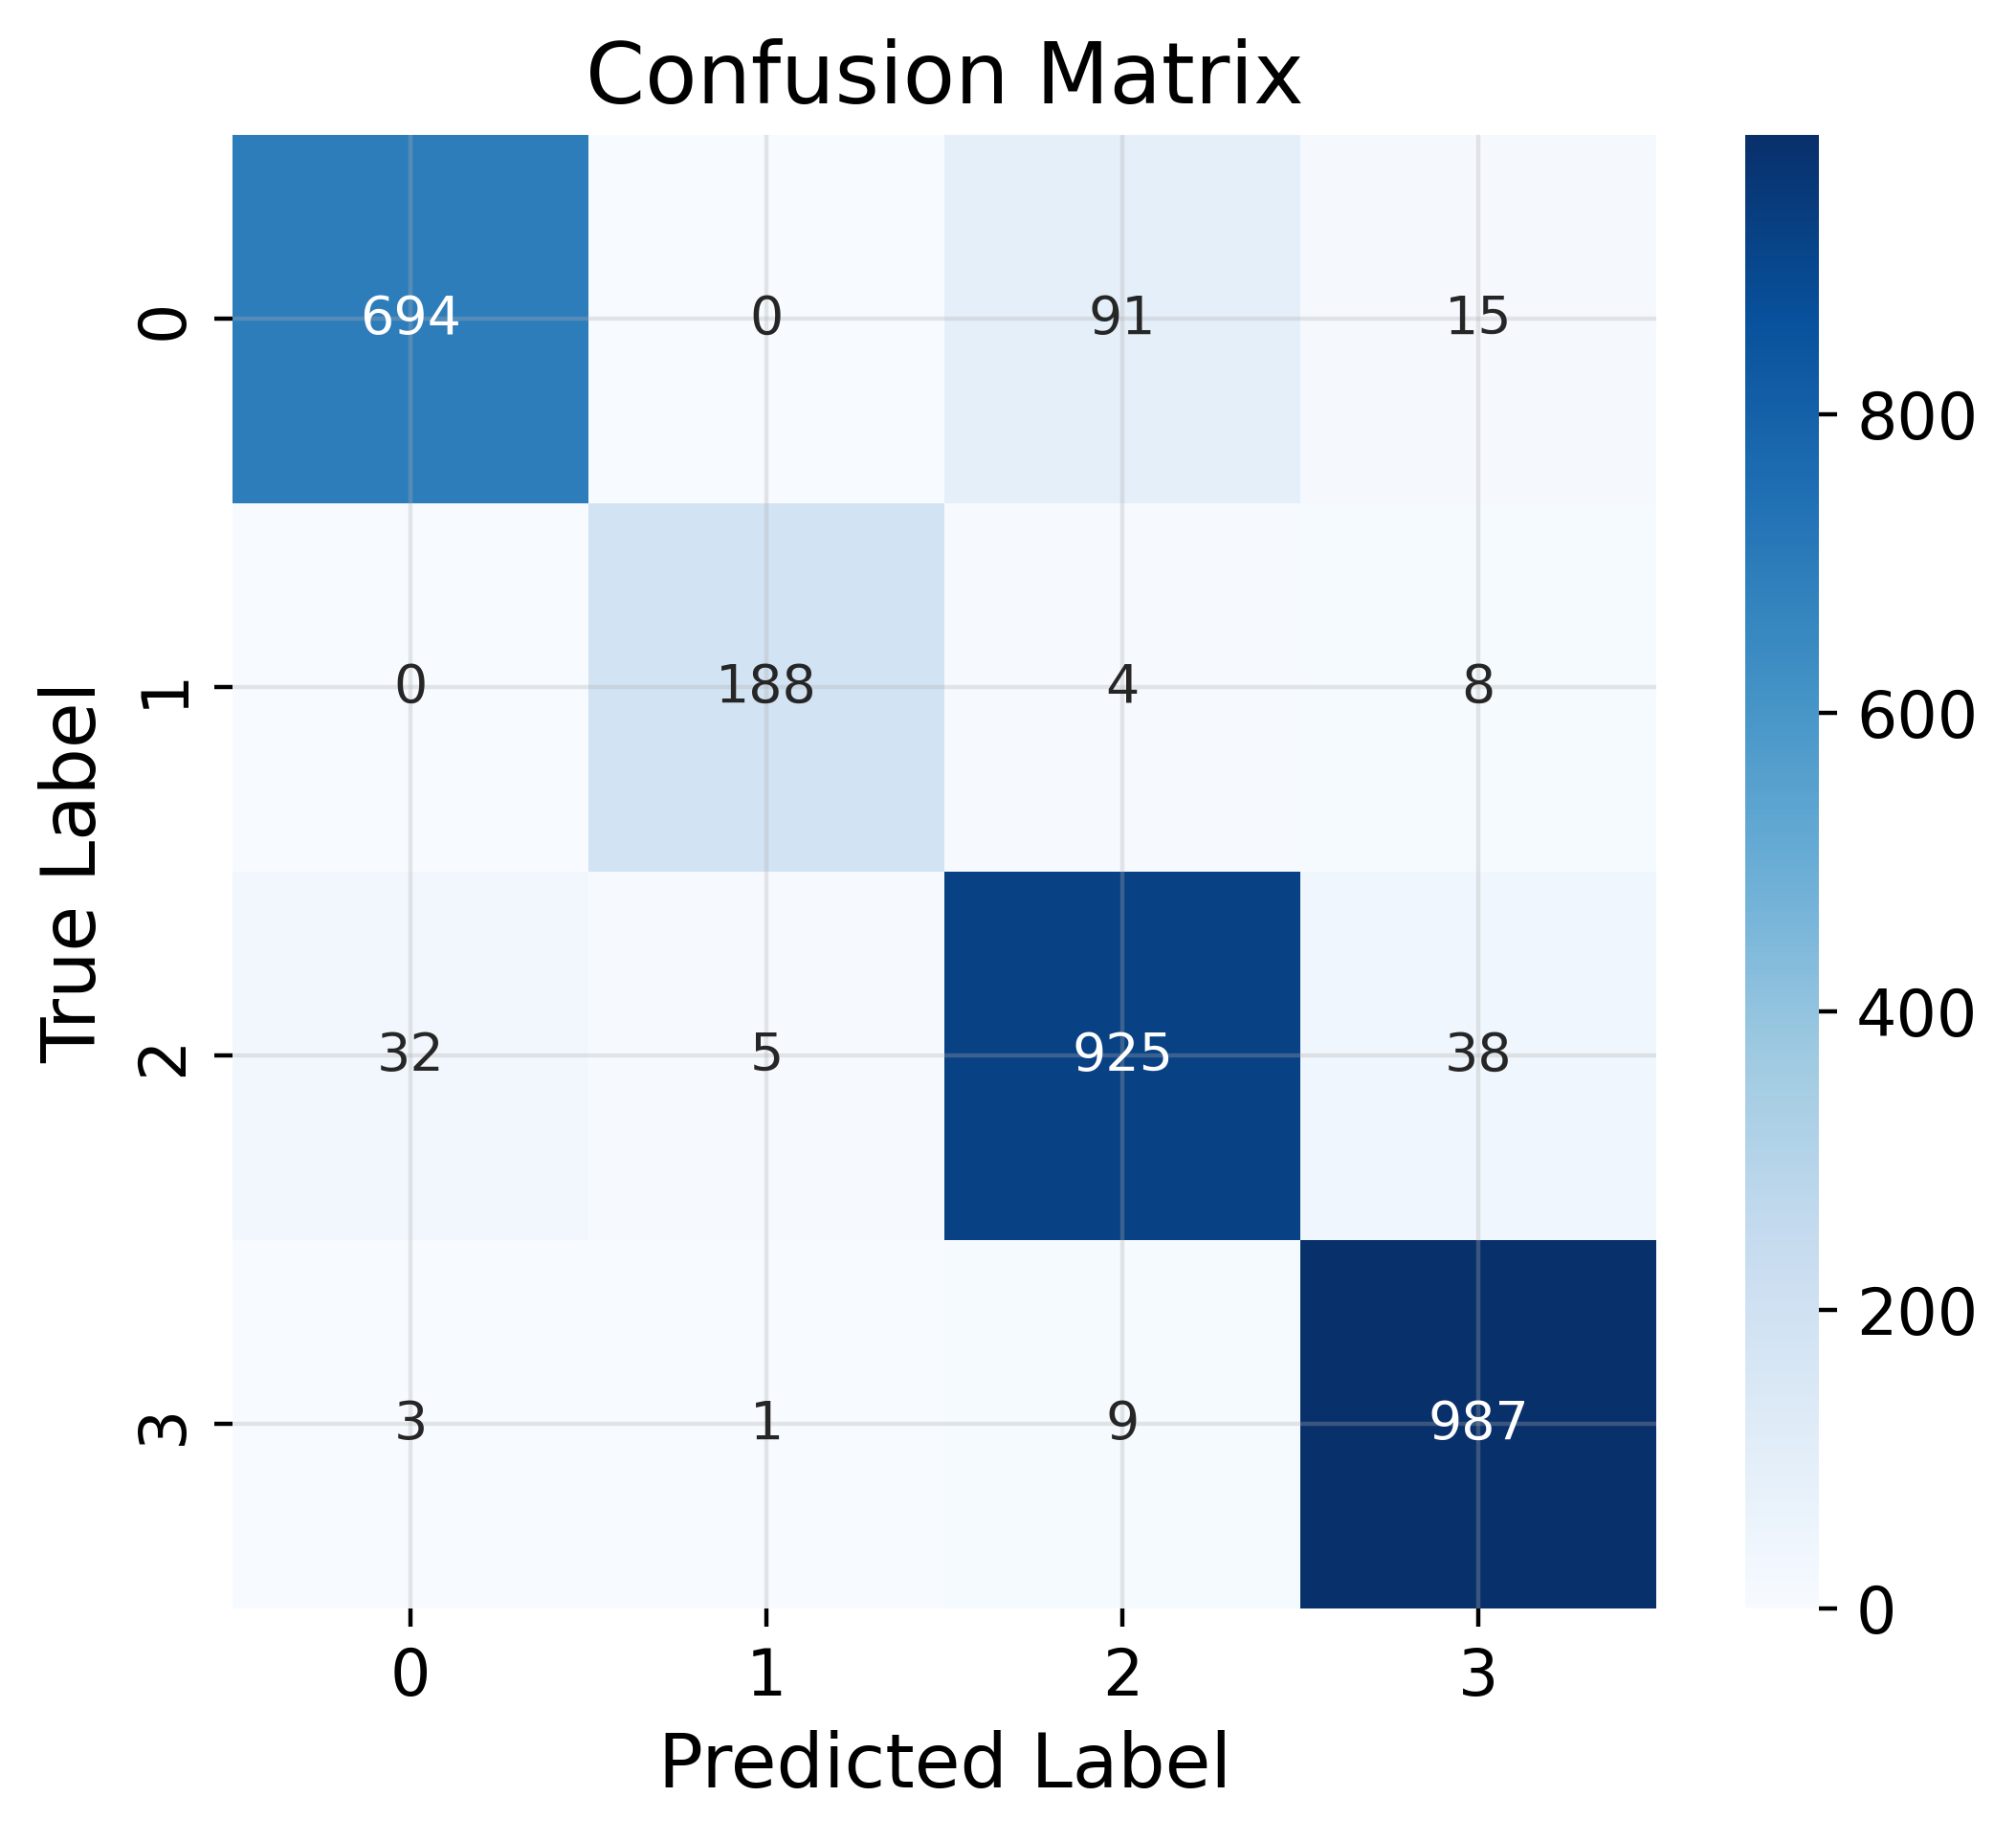

precision  recall  f1-score  support   jaccard   roc_auc
0   0.951989  0.8675  0.907783    800.0  0.831138  0.902644
1   0.969072  0.9400  0.954315    200.0  0.912621  0.945507
2   0.898931  0.9250  0.911779   1000.0  0.837862  0.933992
3   0.941794  0.9870  0.963867   1000.0  0.930254  0.978483

In [10]:
cm = ClusteringMetrics.confusion_matrix(
    torch.tensor(y_true, dtype=torch.long),
    torch.tensor(matched_pred, dtype=torch.long)
)
print("\nConfusion Matrix:\n", cm)

report = ClusteringMetrics.classification_report(
    torch.tensor(y_true, dtype=torch.long),
    torch.tensor(matched_pred, dtype=torch.long)
)
print("\nClassification Report:\n", report)

# Heatmap of confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Convert classification report to a DataFrame for display
report_df = pd.DataFrame(report).T
report_df


Computing KL(p||q) for different numbers of components...


100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


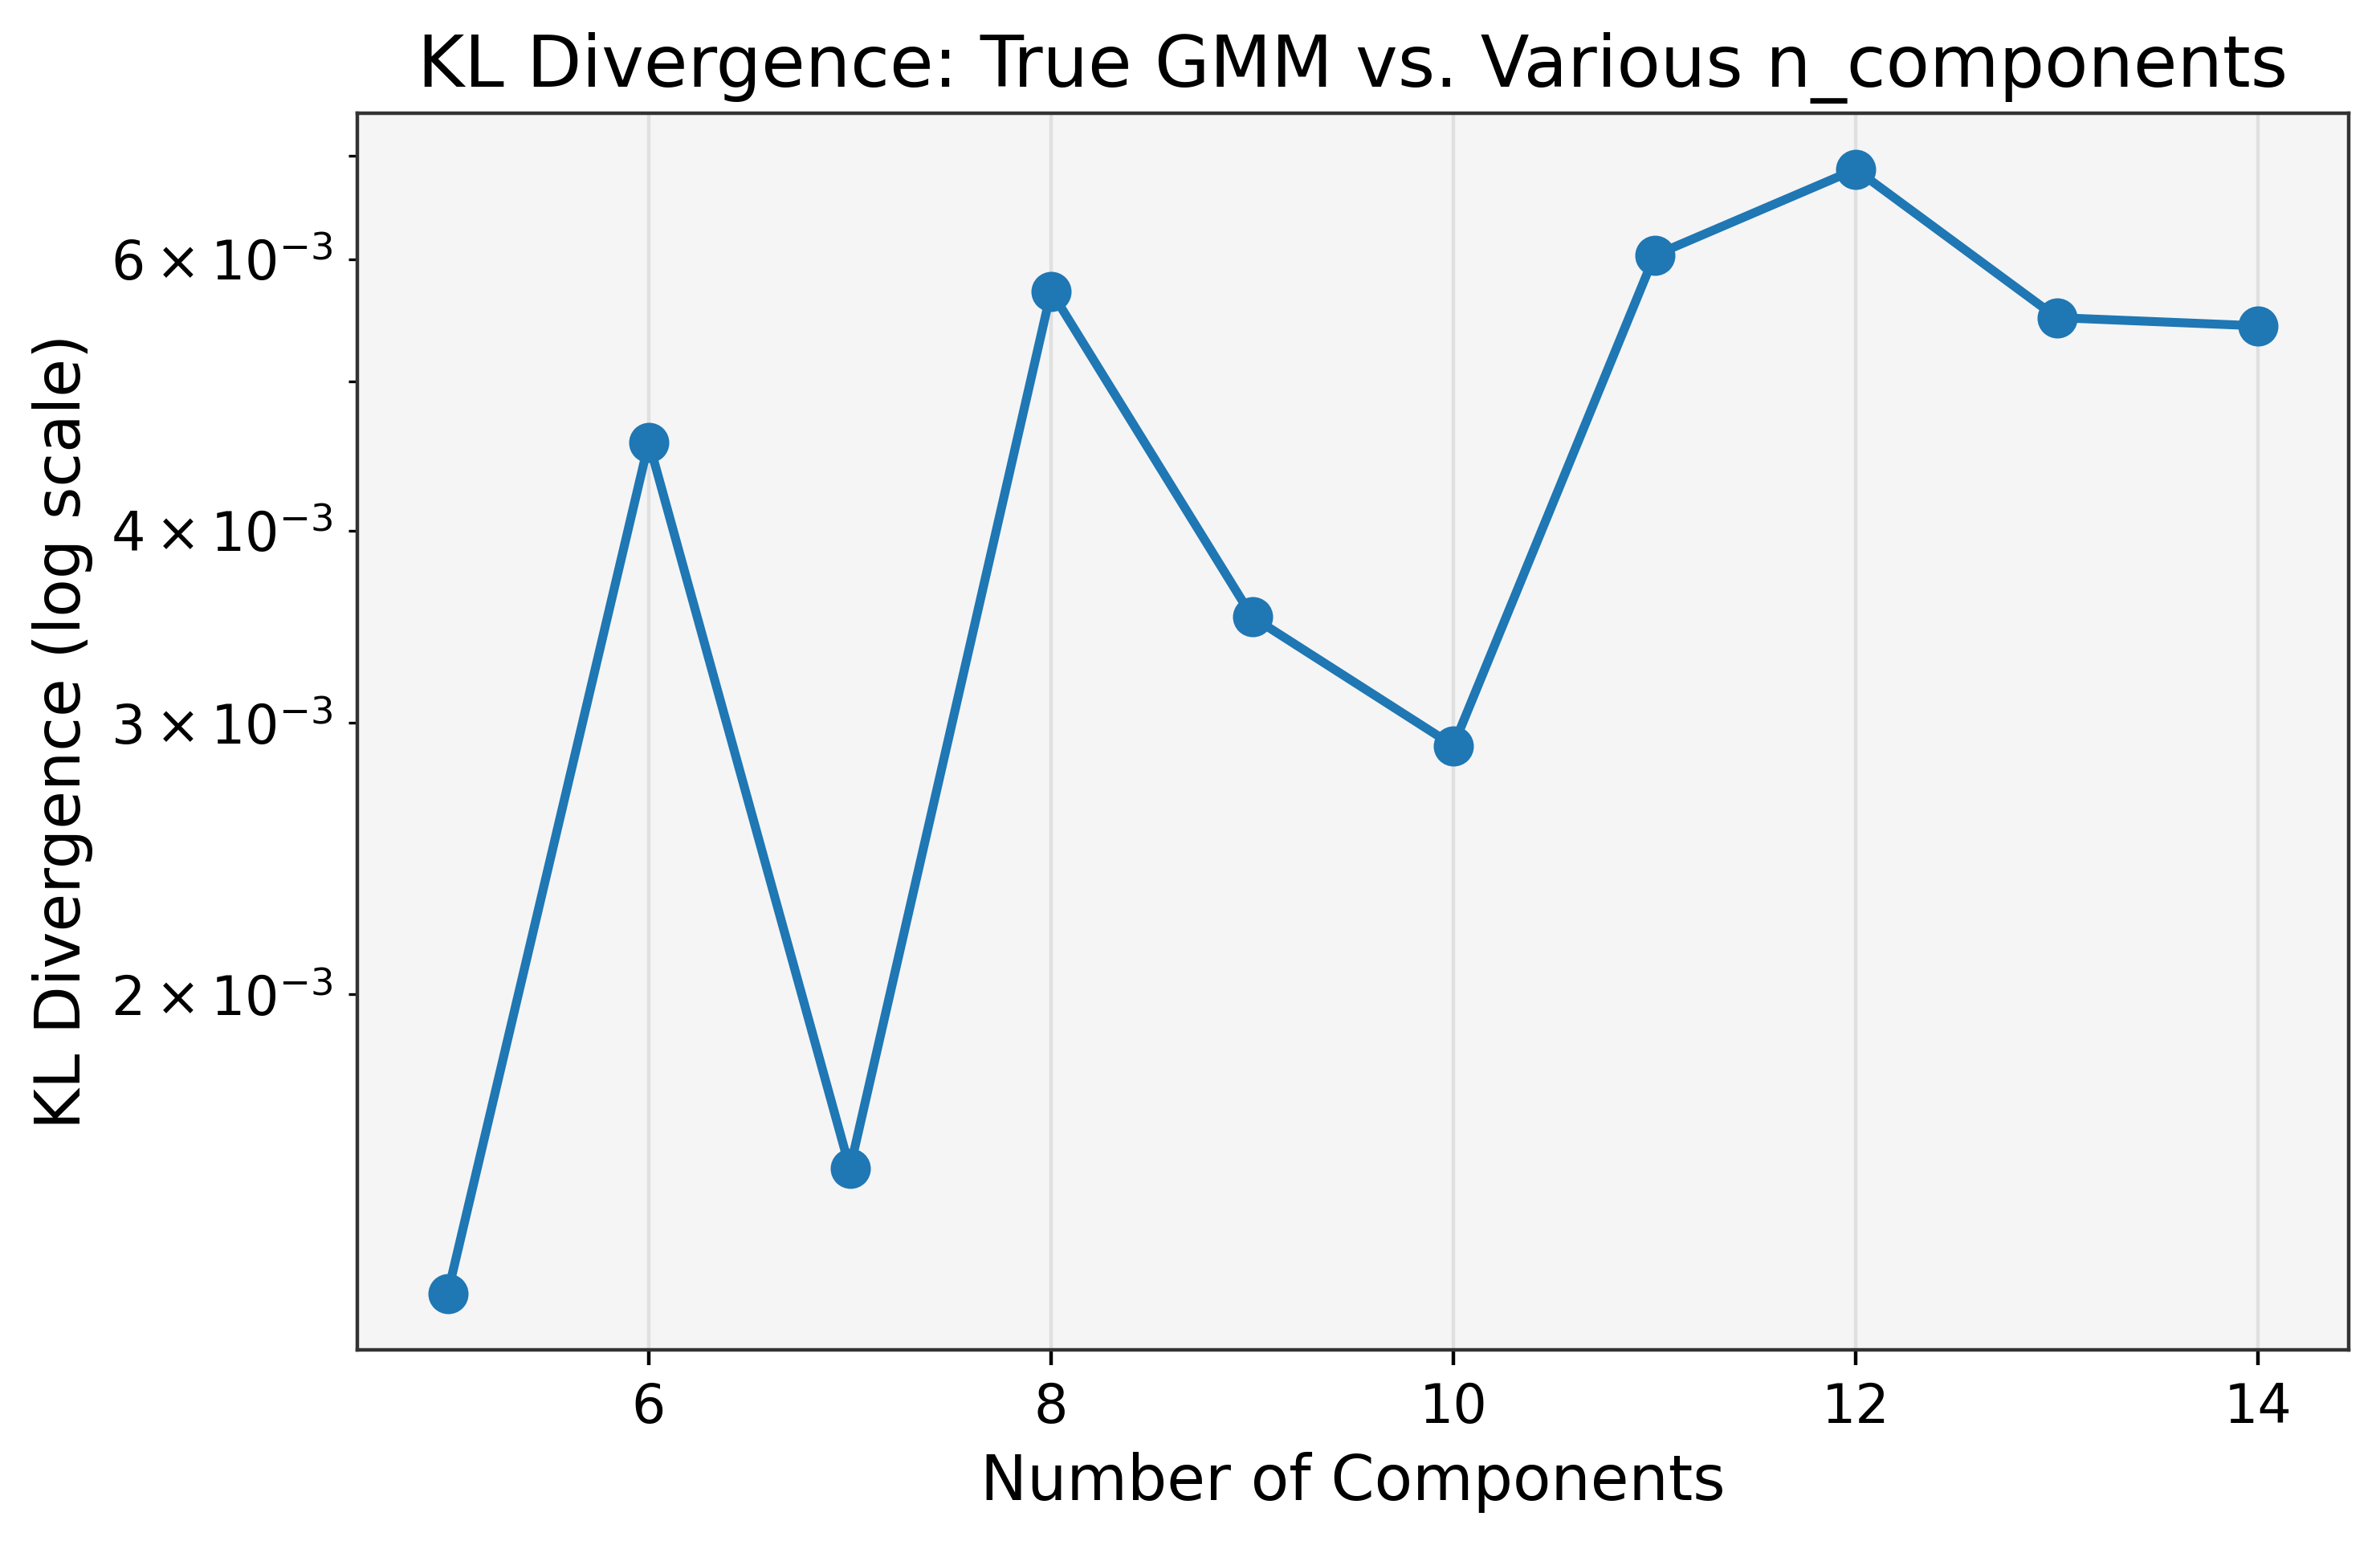

In [7]:
RUN_KL_DIVERGENCE = True
if RUN_KL_DIVERGENCE:
    print("Computing KL(p||q) for different numbers of components...")
    gmm_true = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type='full',
        max_iter=1000,
        init_params='kmeans',
        device=device
    )
    gmm_true.fit(X_tensor)
    
    test_range = np.arange(5, 15)
    kl_vals = torch.zeros(len(test_range), device=device)
    for i, n in tqdm(enumerate(test_range), total=len(test_range)):
        gmm_test = GaussianMixture(
            n_features=n_features,
            n_components=n,
            covariance_type='full',
            max_iter=1000,
            init_params='kmeans',
            device=device
        )
        gmm_test.fit(X_tensor)
        
        kl_vals[i] = ClusteringMetrics.kl_divergence_gmm(gmm_true, gmm_test, n_samples=10000)

    plt.figure(figsize=(8, 5))
    plt.plot(test_range, kl_vals.cpu().numpy(), marker='o')
    plt.yscale('log')
    plt.title("KL Divergence: True GMM vs. Various n_components")
    plt.xlabel("Number of Components")
    plt.ylabel("KL Divergence (log scale)")
    plt.grid(True)
    plt.show()
